In [1]:

# PyTorch
import torchvision
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn
import torchmetrics

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14



In [2]:
save_file_name = 'vgg16-transfer-4.pt'
checkpoint_path = 'vgg16-transfer-4.pth'
# Change to fit hardware
batch_size = 128

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
2 gpus detected.


In [32]:
# define transformations that you wish to apply on image
# define transformations that you wish to apply on image
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        #transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        #transforms.ColorJitter(brightness=2, contrast=0, saturation=0, hue=0),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}





In [57]:
#  Load the datasets with ImageFolder
image_datasets = {
    'train': 
    torchvision.datasets.ImageFolder(root='/data/plic_imaging/data/train5', transform=data_transforms['train']),
    'validation': 
    torchvision.datasets.ImageFolder(root='/data/plic_imaging/data/test5',  transform=data_transforms['validation'])
}

In [58]:
#define data loaders 
#To avoid loading all of the data into memory at once, we use training DataLoaders. 
#First, we create a dataset object from the image folders, and then we pass these to a DataLoader. At training time, the DataLoader will load the images from disk, apply the transformations, and yield a batch. 
#To train and validation, we'll iterate through all the batches in the respective DataLoader.

batch_size=32
dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=0),  
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=0)  
}

In [59]:
model = models.resnet50(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [60]:
# weights in the lower (convolutional) layer frozen (SI')
lt=8
cntr=0

for child in model.children():
  cntr +=1
if cntr < lt:

    for param in child.parameters():
        param.requires_grad = False

In [61]:
#Add on classifier(2)
n_inputs = model.fc.in_features
model.fc = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 2), nn.LogSoftmax(dim=1))


In [62]:
if train_on_gpu:
    model = model.to('cuda')

if multi_gpu:
    model = nn.DataParallel(model)

In [11]:
summary(
        model, input_size=(3, 224, 224), batch_size=batch_size, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 112, 112]           9,408
       BatchNorm2d-2         [32, 64, 112, 112]             128
              ReLU-3         [32, 64, 112, 112]               0
         MaxPool2d-4           [32, 64, 56, 56]               0
            Conv2d-5           [32, 64, 56, 56]           4,096
       BatchNorm2d-6           [32, 64, 56, 56]             128
              ReLU-7           [32, 64, 56, 56]               0
            Conv2d-8           [32, 64, 56, 56]          36,864
       BatchNorm2d-9           [32, 64, 56, 56]             128
             ReLU-10           [32, 64, 56, 56]               0
           Conv2d-11          [32, 256, 56, 56]          16,384
      BatchNorm2d-12          [32, 256, 56, 56]             512
           Conv2d-13          [32, 256, 56, 56]          16,384
      BatchNorm2d-14          [32, 256,

In [63]:
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters())

In [64]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []
    
   # initialize metrics
    train_bal_acc = torchmetrics.Accuracy(average='macro', num_classes=2).to('cuda')
    valid_bal_acc = torchmetrics.Accuracy(average='macro', num_classes=2).to('cuda')
    train_mcc=torchmetrics.MatthewsCorrCoef(num_classes=2).to('cuda')
    valid_mcc=torchmetrics.MatthewsCorrCoef(num_classes=2).to('cuda')
    train_recall=torchmetrics.Recall().to('cuda')
    valid_recall=torchmetrics.Recall().to('cuda')
    train_precision=torchmetrics.Precision().to('cuda')
    valid_precision=torchmetrics.Precision().to('cuda')

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            #train on gpu
            data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)
            
           

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()
            
            

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)
            
            #other metrics
            batch_bal_acc = train_bal_acc(output,target)
            batch_mcc = train_mcc(output,target)
            batch_precision = train_precision(output,target)
            batch_recall = train_recall(output,target)
            

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)
                   
                    

                    # Validation loss
                    loss = criterion(output, target)
                    
                    
                    
                    
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    #other metrics
                    valid_bal_acc.update(output, target)
                    valid_mcc.update(output, target)
                    valid_precision.update(output, target)
                    valid_recall.update(output, target)
                    
                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)
                    
                    
                
                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)
                
                # other metric on all batches using custom accumulation
                total_train_bal_acc=train_bal_acc.compute()
                total_valid_bal_acc = valid_bal_acc.compute()
                total_train_mcc=train_mcc.compute()
                total_valid_mcc = valid_mcc.compute()
                total_train_recall=train_recall.compute()
                total_valid_recall = valid_recall.compute()
                total_train_precision=train_precision.compute()
                total_valid_precision = valid_precision.compute()
                
                #history
                history.append([train_loss, valid_loss, train_acc, valid_acc,
                                total_train_bal_acc, total_valid_bal_acc,
                                total_train_mcc, total_valid_mcc,
                                total_train_recall, total_valid_recall,
                                total_train_precision, total_valid_precision])
                                

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(f'\t\tTraining Bal Acc: {total_train_bal_acc:.4f} \tValidation Bal Acc: {total_valid_bal_acc:.4f}')
                    print(f'\t\tTraining MCC: {total_train_mcc:.4f} \tValidation MCC: {total_valid_mcc:.4f}')
                    
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )
                
                #reset metics
                train_bal_acc.reset()
                valid_bal_acc.reset()
                train_mcc.reset()
                valid_mcc.reset()
                train_recall.reset()
                valid_recall.reset()
                train_precision.reset()
                valid_precision.reset()

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc', 'total_train_bal_acc', 'total_valid_bal_acc',
                                'total_train_mcc', 'total_valid_mcc',
                                'total_train_recall', 'total_valid_recall',
                                'total_train_precision', 'total_valid_precision'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc','total_train_bal_acc', 'total_valid_bal_acc',
                                'total_train_mcc', 'total_valid_mcc',
                                'total_train_recall', 'total_valid_recall',
                                'total_train_precision', 'total_valid_precision'])
    return model, history

   
                                

In [65]:
model, history = train(
    model,
    criterion,  
    optimizer,
    dataloaders['train'],
    dataloaders['validation'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=30,
    print_every=2)

Starting Training from Scratch.

Epoch: 1	100.00% complete. 134.13 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.6789 	Validation Loss: 0.7271
		Training Bal Acc: 0.5017 	Validation Bal Acc: 0.5000
		Training MCC: 0.0145 	Validation MCC: 0.0000
		Training Accuracy: 57.86%	 Validation Accuracy: 49.99%
Epoch: 3	100.00% complete. 133.71 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.6736 	Validation Loss: 0.7559
		Training Bal Acc: 0.5017 	Validation Bal Acc: 0.5000
		Training MCC: 0.0123 	Validation MCC: 0.0000
		Training Accuracy: 57.79%	 Validation Accuracy: 49.99%
Epoch: 5	100.00% complete. 133.93 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.6582 	Validation Loss: 0.7413
		Training Bal Acc: 0.5527 	Validation Bal Acc: 0.5044
		Training MCC: 0.1401 	Validation MCC: 0.0235
		Training Accuracy: 60.44%	 Validation Accuracy: 50.43%
Epoch: 7	100.00% complete. 134.29 seconds elapsed in epoch.
Epoch: 7 	Training Loss: 0.6422 	Validation Loss: 0.7083
		Training Bal Acc: 0.

In [66]:
history

,train_loss,valid_loss,train_acc,valid_acc,total_train_bal_acc,total_valid_bal_acc,total_train_mcc,total_valid_mcc,total_train_recall,total_valid_recall,total_train_precision,total_valid_precision
0,0.683986,0.732142,0.577132,0.508763,"tensor(0.5140, device='cuda:0')","tensor(0.5089, device='cuda:0')","tensor(0.0464, device='cuda:0')","tensor(0.0383, device='cuda:0')","tensor(0.5771, device='cuda:0')","tensor(0.5088, device='cuda:0')","tensor(0.5771, device='cuda:0')","tensor(0.5088, device='cuda:0')"
1,0.678877,0.727079,0.578584,0.499869,"tensor(0.5017, device='cuda:0')","tensor(0.5000, device='cuda:0')","tensor(0.0145, device='cuda:0')","tensor(0., device='cuda:0')","tensor(0.5786, device='cuda:0')","tensor(0.4999, device='cuda:0')","tensor(0.5786, device='cuda:0')","tensor(0.4999, device='cuda:0')"
2,0.675778,0.794546,0.583122,0.499869,"tensor(0.5108, device='cuda:0')","tensor(0.5000, device='cuda:0')","tensor(0.0536, device='cuda:0')","tensor(0., device='cuda:0')","tensor(0.5831, device='cuda:0')","tensor(0.4999, device='cuda:0')","tensor(0.5831, device='cuda:0')","tensor(0.4999, device='cuda:0')"
3,0.673613,0.755946,0.577858,0.499869,"tensor(0.5017, device='cuda:0')","tensor(0.5000, device='cuda:0')","tensor(0.0123, device='cuda:0')","tensor(0., device='cuda:0')","tensor(0.5779, device='cuda:0')","tensor(0.4999, device='cuda:0')","tensor(0.5779, device='cuda:0')","tensor(0.4999, device='cuda:0')"
4,0.667251,0.712061,0.587568,0.522888,"tensor(0.5259, device='cuda:0')","tensor(0.5229, device='cuda:0')","tensor(0.0830, device='cuda:0')","tensor(0.0486, device='cuda:0')","tensor(0.5876, device='cuda:0')","tensor(0.5229, device='cuda:0')","tensor(0.5876, device='cuda:0')","tensor(0.5229, device='cuda:0')"
5,0.658223,0.741344,0.604356,0.504316,"tensor(0.5527, device='cuda:0')","tensor(0.5044, device='cuda:0')","tensor(0.1401, device='cuda:0')","tensor(0.0235, device='cuda:0')","tensor(0.6044, device='cuda:0')","tensor(0.5043, device='cuda:0')","tensor(0.6044, device='cuda:0')","tensor(0.5043, device='cuda:0')"
6,0.646666,0.670477,0.617604,0.578342,"tensor(0.5768, device='cuda:0')","tensor(0.5784, device='cuda:0')","tensor(0.1802, device='cuda:0')","tensor(0.1642, device='cuda:0')","tensor(0.6176, device='cuda:0')","tensor(0.5783, device='cuda:0')","tensor(0.6176, device='cuda:0')","tensor(0.5783, device='cuda:0')"
7,0.642221,0.708302,0.622777,0.546691,"tensor(0.5811, device='cuda:0')","tensor(0.5468, device='cuda:0')","tensor(0.1921, device='cuda:0')","tensor(0.1396, device='cuda:0')","tensor(0.6228, device='cuda:0')","tensor(0.5467, device='cuda:0')","tensor(0.6228, device='cuda:0')","tensor(0.5467, device='cuda:0')"
8,0.636538,0.785633,0.626770,0.504316,"tensor(0.5871, device='cuda:0')","tensor(0.5042, device='cuda:0')","tensor(0.2027, device='cuda:0')","tensor(0.0402, device='cuda:0')","tensor(0.6268, device='cuda:0')","tensor(0.5043, device='cuda:0')","tensor(0.6268, device='cuda:0')","tensor(0.5043, device='cuda:0')"
9,0.629706,0.654693,0.633666,0.618886,"tensor(0.5971, device='cuda:0')","tensor(0.6189, device='cuda:0')","tensor(0.2204, device='cuda:0')","tensor(0.2380, device='cuda:0')","tensor(0.6337, device='cuda:0')","tensor(0.6189, device='cuda:0')","tensor(0.6337, device='cuda:0')","tensor(0.6189, device='cuda:0')"


In [67]:
model, history = train(
    model,
    criterion,  
    optimizer,
    dataloaders['train'],
    dataloaders['validation'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=30,
    print_every=2)

Model has been trained for: 15 epochs.

Epoch: 1	100.00% complete. 133.52 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.6189 	Validation Loss: 0.7315
		Training Bal Acc: 0.6301 	Validation Bal Acc: 0.5578
		Training MCC: 0.2821 	Validation MCC: 0.1633
		Training Accuracy: 65.95%	 Validation Accuracy: 55.77%
Epoch: 3	100.00% complete. 133.83 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.6148 	Validation Loss: 0.6459
		Training Bal Acc: 0.6370 	Validation Bal Acc: 0.6123
		Training MCC: 0.2845 	Validation MCC: 0.2248
		Training Accuracy: 65.80%	 Validation Accuracy: 61.23%
Epoch: 5	100.00% complete. 133.89 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.6088 	Validation Loss: 0.6496
		Training Bal Acc: 0.6496 	Validation Bal Acc: 0.6045
		Training MCC: 0.3141 	Validation MCC: 0.2107
		Training Accuracy: 67.28%	 Validation Accuracy: 60.45%
Epoch: 7	100.00% complete. 133.43 seconds elapsed in epoch.
Epoch: 7 	Training Loss: 0.6049 	Validation Loss: 0.6954
		Training Bal 

In [68]:
history

,train_loss,valid_loss,train_acc,valid_acc,total_train_bal_acc,total_valid_bal_acc,total_train_mcc,total_valid_mcc,total_train_recall,total_valid_recall,total_train_precision,total_valid_precision
0,0.624562,0.681411,0.644102,0.592728,"tensor(0.6091, device='cuda:0')","tensor(0.5928, device='cuda:0')","tensor(0.2451, device='cuda:0')","tensor(0.2212, device='cuda:0')","tensor(0.6441, device='cuda:0')","tensor(0.5927, device='cuda:0')","tensor(0.6441, device='cuda:0')","tensor(0.5927, device='cuda:0')"
1,0.618948,0.731480,0.659528,0.557677,"tensor(0.6301, device='cuda:0')","tensor(0.5578, device='cuda:0')","tensor(0.2821, device='cuda:0')","tensor(0.1633, device='cuda:0')","tensor(0.6595, device='cuda:0')","tensor(0.5577, device='cuda:0')","tensor(0.6595, device='cuda:0')","tensor(0.5577, device='cuda:0')"
2,0.618849,0.748961,0.664519,0.595082,"tensor(0.6380, device='cuda:0')","tensor(0.5951, device='cuda:0')","tensor(0.2945, device='cuda:0')","tensor(0.2196, device='cuda:0')","tensor(0.6645, device='cuda:0')","tensor(0.5951, device='cuda:0')","tensor(0.6645, device='cuda:0')","tensor(0.5951, device='cuda:0')"
3,0.614753,0.645943,0.657985,0.612346,"tensor(0.6370, device='cuda:0')","tensor(0.6123, device='cuda:0')","tensor(0.2845, device='cuda:0')","tensor(0.2248, device='cuda:0')","tensor(0.6580, device='cuda:0')","tensor(0.6123, device='cuda:0')","tensor(0.6580, device='cuda:0')","tensor(0.6123, device='cuda:0')"
4,0.613219,0.665877,0.663975,0.604499,"tensor(0.6434, device='cuda:0')","tensor(0.6045, device='cuda:0')","tensor(0.2974, device='cuda:0')","tensor(0.2096, device='cuda:0')","tensor(0.6640, device='cuda:0')","tensor(0.6045, device='cuda:0')","tensor(0.6640, device='cuda:0')","tensor(0.6045, device='cuda:0')"
5,0.608807,0.649589,0.672777,0.604499,"tensor(0.6496, device='cuda:0')","tensor(0.6045, device='cuda:0')","tensor(0.3141, device='cuda:0')","tensor(0.2107, device='cuda:0')","tensor(0.6728, device='cuda:0')","tensor(0.6045, device='cuda:0')","tensor(0.6728, device='cuda:0')","tensor(0.6045, device='cuda:0')"
6,0.602796,0.696765,0.681216,0.566571,"tensor(0.6594, device='cuda:0')","tensor(0.5666, device='cuda:0')","tensor(0.3330, device='cuda:0')","tensor(0.1428, device='cuda:0')","tensor(0.6812, device='cuda:0')","tensor(0.5666, device='cuda:0')","tensor(0.6812, device='cuda:0')","tensor(0.5666, device='cuda:0')"
7,0.604883,0.695418,0.672595,0.601622,"tensor(0.6548, device='cuda:0')","tensor(0.6017, device='cuda:0')","tensor(0.3179, device='cuda:0')","tensor(0.2322, device='cuda:0')","tensor(0.6726, device='cuda:0')","tensor(0.6016, device='cuda:0')","tensor(0.6726, device='cuda:0')","tensor(0.6016, device='cuda:0')"
8,0.601003,0.658893,0.678403,0.615224,"tensor(0.6566, device='cuda:0')","tensor(0.6152, device='cuda:0')","tensor(0.3270, device='cuda:0')","tensor(0.2307, device='cuda:0')","tensor(0.6784, device='cuda:0')","tensor(0.6152, device='cuda:0')","tensor(0.6784, device='cuda:0')","tensor(0.6152, device='cuda:0')"


In [16]:
#trasformation of history(runnare solo se le colonne sono da sistemare)
col= ['total_train_bal_acc',
 'total_valid_bal_acc',
 'total_train_mcc',
 'total_valid_mcc',
 'total_train_recall',
 'total_valid_recall',
 'total_train_precision',
 'total_valid_precision']
for c in col:
    history[c]=history[c].str[7:13]
#history.at[0,'total_valid_mcc']='0.0000'
#istory.at[1,'total_valid_mcc']='0.0000'   

IndexError: dimension specified as 0 but tensor has no dimensions

Text(0.5, 1.0, 'Training and Validation Losses')

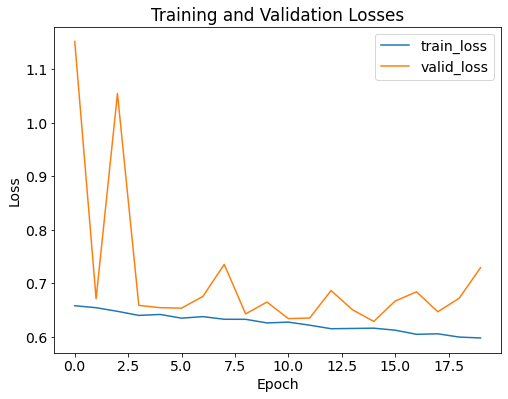

In [17]:
#training result
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')

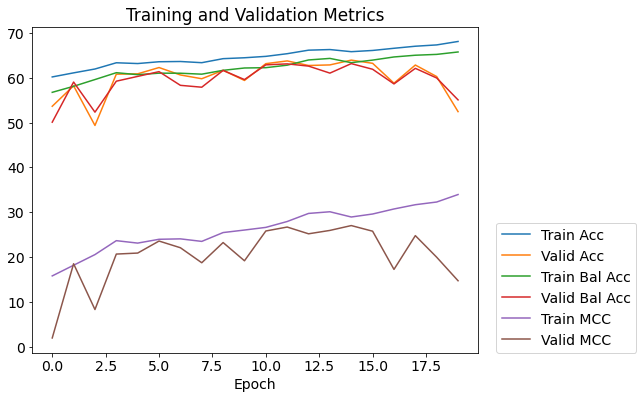

In [23]:
plt.figure(figsize=(8, 6))

plt.plot(100*history['train_acc'], label='Train Acc')
plt.plot(100*history['valid_acc'], label='Valid Acc')
plt.plot(100*history['total_train_bal_acc'], label='Train Bal Acc')
plt.plot(100*history['total_valid_bal_acc'], label='Valid Bal Acc')
plt.plot(100*history['total_train_mcc'], label='Train MCC')
plt.plot(100*history['total_valid_mcc'], label='Valid MCC')
plt.xlabel('Epoch')


plt.title('Training and Validation Metrics')
plt.legend(loc=(1.04,0))

In [24]:
plt.savefig('metrics_bestmodel2.png')

<Figure size 432x288 with 0 Axes>

In [56]:
history.to_csv('history4.csv')